# This is my attempt on performing a basic CNN model on the MNIST data.

John Figueroa
IS 7033

The purpose of this code is to be introduced to using PyTorch and get some decent results with a very common dataset (the MNIST dataset).

Code was written based off https://nextjournal.com/gkoehler/pytorch-mnist 

In [ ]:
import torch
import torchvision
import torch.nn as nn

Importing the data and spliting into test/train

In [2]:
mnist = torchvision.datasets.MNIST('/files/', download=True)
mnist_train = torchvision.datasets.MNIST('/files/', train=True, download=True)
mnist_test = torchvision.datasets.MNIST('/files/', train=False, download=True)

Defining the Hyperparameters

In [17]:
random_seed = 1
epochs = 10
learning_rate = 0.1
batch_size_train = 100
batch_size_test = 100
momentum = 0.5
log_interval = 10
display_step = 50
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

Creating the training & test model function

In [18]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

In [19]:
test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

Just trying to get an example and see if the data loaded

In [20]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [21]:
example_data.shape

torch.Size([100, 1, 28, 28])

some plotting of examples with the "ground truth"

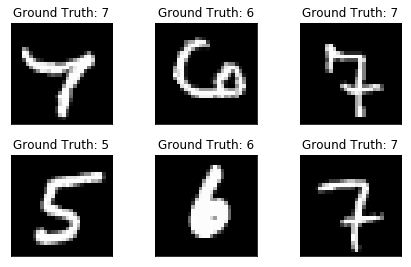

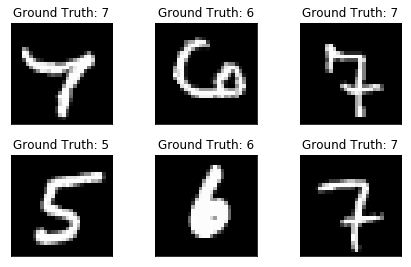

In [22]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

# Building the Network

In [23]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

Here we are defining a nn model and forward propogation with a 2d layers and max pooling features. Also, a dropout step is added.

In [24]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [25]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

# Training the model

In [26]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(epochs + 1)]

In [27]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
   #   torch.save(network.state_dict(), '/results/model.pth')
    #  torch.save(optimizer.state_dict(), '/results/optimizer.pth')

In [28]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [29]:
test()
for epoch in range(1, epochs + 1):
  train(epoch)
  test()

C:\Users\plk1544\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\plk1544\Anaconda3\lib\site-packages\torch\nn\_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3004, Accuracy: 751/10000 (7%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.271784
Train Epoch: 1 [1000/60000 (2%)]	Loss: 2.093460
Train Epoch: 1 [2000/60000 (3%)]	Loss: 1.645728
Train Epoch: 1 [3000/60000 (5%)]	Loss: 1.032155
Train Epoch: 1 [4000/60000 (7%)]	Loss: 1.070691
Train Epoch: 1 [5000/60000 (8%)]	Loss: 0.974950
Train Epoch: 1 [6000/60000 (10%)]	Loss: 0.879852
Train Epoch: 1 [7000/60000 (12%)]	Loss: 0.793489
Train Epoch: 1 [8000/60000 (13%)]	Loss: 0.745545
Train Epoch: 1 [9000/60000 (15%)]	Loss: 0.637609
Train Epoch: 1 [10000/60000 (17%)]	Loss: 0.686899
Train Epoch: 1 [11000/60000 (18%)]	Loss: 0.551023
Train Epoch: 1 [12000/60000 (20%)]	Loss: 0.608286
Train Epoch: 1 [13000/60000 (22%)]	Loss: 0.649414
Train Epoch: 1 [14000/60000 (23%)]	Loss: 0.474134
Train Epoch: 1 [15000/60000 (25%)]	Loss: 0.362591
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.539907
Train Epoch: 1 [17000/60000 (28%)]	Loss: 0.492546
Train Epoch: 1 [18000/60000 (30%)]	Loss: 0.471400
Train Epoch: 

Train Epoch: 3 [42000/60000 (70%)]	Loss: 0.198328
Train Epoch: 3 [43000/60000 (72%)]	Loss: 0.082852
Train Epoch: 3 [44000/60000 (73%)]	Loss: 0.234275
Train Epoch: 3 [45000/60000 (75%)]	Loss: 0.162350
Train Epoch: 3 [46000/60000 (77%)]	Loss: 0.120458
Train Epoch: 3 [47000/60000 (78%)]	Loss: 0.302999
Train Epoch: 3 [48000/60000 (80%)]	Loss: 0.069336
Train Epoch: 3 [49000/60000 (82%)]	Loss: 0.201145
Train Epoch: 3 [50000/60000 (83%)]	Loss: 0.284113
Train Epoch: 3 [51000/60000 (85%)]	Loss: 0.170861
Train Epoch: 3 [52000/60000 (87%)]	Loss: 0.205924
Train Epoch: 3 [53000/60000 (88%)]	Loss: 0.144623
Train Epoch: 3 [54000/60000 (90%)]	Loss: 0.112953
Train Epoch: 3 [55000/60000 (92%)]	Loss: 0.177262
Train Epoch: 3 [56000/60000 (93%)]	Loss: 0.130513
Train Epoch: 3 [57000/60000 (95%)]	Loss: 0.245694
Train Epoch: 3 [58000/60000 (97%)]	Loss: 0.139649
Train Epoch: 3 [59000/60000 (98%)]	Loss: 0.125785

Test set: Avg. loss: 0.0593, Accuracy: 9814/10000 (98%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.2122

Train Epoch: 6 [24000/60000 (40%)]	Loss: 0.128772
Train Epoch: 6 [25000/60000 (42%)]	Loss: 0.099184
Train Epoch: 6 [26000/60000 (43%)]	Loss: 0.138853
Train Epoch: 6 [27000/60000 (45%)]	Loss: 0.191678
Train Epoch: 6 [28000/60000 (47%)]	Loss: 0.122700
Train Epoch: 6 [29000/60000 (48%)]	Loss: 0.081359
Train Epoch: 6 [30000/60000 (50%)]	Loss: 0.124113
Train Epoch: 6 [31000/60000 (52%)]	Loss: 0.113422
Train Epoch: 6 [32000/60000 (53%)]	Loss: 0.235823
Train Epoch: 6 [33000/60000 (55%)]	Loss: 0.263779
Train Epoch: 6 [34000/60000 (57%)]	Loss: 0.110843
Train Epoch: 6 [35000/60000 (58%)]	Loss: 0.143936
Train Epoch: 6 [36000/60000 (60%)]	Loss: 0.104908
Train Epoch: 6 [37000/60000 (62%)]	Loss: 0.072191
Train Epoch: 6 [38000/60000 (63%)]	Loss: 0.066824
Train Epoch: 6 [39000/60000 (65%)]	Loss: 0.238665
Train Epoch: 6 [40000/60000 (67%)]	Loss: 0.097583
Train Epoch: 6 [41000/60000 (68%)]	Loss: 0.246592
Train Epoch: 6 [42000/60000 (70%)]	Loss: 0.134096
Train Epoch: 6 [43000/60000 (72%)]	Loss: 0.232624


Train Epoch: 9 [6000/60000 (10%)]	Loss: 0.133764
Train Epoch: 9 [7000/60000 (12%)]	Loss: 0.112468
Train Epoch: 9 [8000/60000 (13%)]	Loss: 0.135427
Train Epoch: 9 [9000/60000 (15%)]	Loss: 0.029217
Train Epoch: 9 [10000/60000 (17%)]	Loss: 0.363363
Train Epoch: 9 [11000/60000 (18%)]	Loss: 0.232082
Train Epoch: 9 [12000/60000 (20%)]	Loss: 0.093244
Train Epoch: 9 [13000/60000 (22%)]	Loss: 0.181410
Train Epoch: 9 [14000/60000 (23%)]	Loss: 0.076875
Train Epoch: 9 [15000/60000 (25%)]	Loss: 0.255428
Train Epoch: 9 [16000/60000 (27%)]	Loss: 0.068585
Train Epoch: 9 [17000/60000 (28%)]	Loss: 0.063076
Train Epoch: 9 [18000/60000 (30%)]	Loss: 0.195720
Train Epoch: 9 [19000/60000 (32%)]	Loss: 0.168354
Train Epoch: 9 [20000/60000 (33%)]	Loss: 0.205837
Train Epoch: 9 [21000/60000 (35%)]	Loss: 0.237014
Train Epoch: 9 [22000/60000 (37%)]	Loss: 0.269831
Train Epoch: 9 [23000/60000 (38%)]	Loss: 0.168319
Train Epoch: 9 [24000/60000 (40%)]	Loss: 0.119888
Train Epoch: 9 [25000/60000 (42%)]	Loss: 0.081252
Trai

My average loss was ~4.2% with an accuracy of over 98% within the 10 epochs suggested to be used.  Now we will graph those (The model's performance).

Text(0,0.5,'negative log likelihood loss')

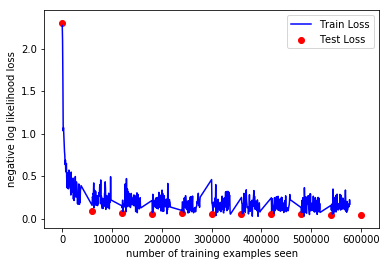

In [30]:
#Model Performance
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
#fig

In [31]:
with torch.no_grad():
  output = network(example_data)

C:\Users\plk1544\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [32]:
len(test_counter)

11

In [33]:
len(test_losses)

11

Here are some examples.

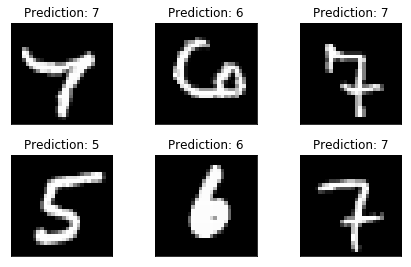

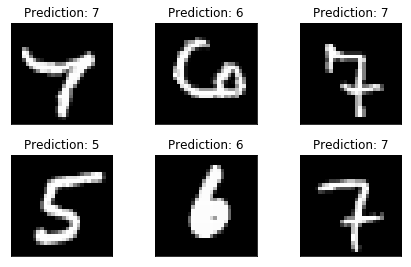

In [34]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
fig